## A1: Data Curation Assignment
## Jack Chen

### Step 1: Data Acquisition

In [1]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

#### We will need to call two wikipedia APIs to retrieve the data.
1. The Legacy Pagecounts API (https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts) provides access to desktop and mobile traffic data from December 2007 through July 2016.
2. The Pageviews API (https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month.

#### Here I setup five dictionaries for the parameters of the API calls.

In [3]:
# Legacy Pagecount API parameters for desktop and mobile
params_legacy_desktop = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007123100",
                # for end use 1st day of month following final month of data
                 "end" : "2016080100"
                    }

params_legacy_mobile = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007123100",
                # for end use 1st day of month following final month of data
                 "end" : "2016080100"
                    }

In [4]:
# Pageviews API parameters for desktop, mobile web and app
params_pageviews_desktop = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021090100'
                        }

params_pageviews_mobile_web = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021090100'
                        }

params_pageviews_mobile_app = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021090100'
                        }

In [5]:
# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/jchen023',
    'From': 'jchen023@uw.edu'
}

#### I will be calling the APIs five times to retrieve desktop and mobile data from the legacy pagecount API; desktop, mobile web and app foor pageviews API.

In [6]:
def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    return response

In [7]:
legacy_desktop = api_call(endpoint_legacy, params_legacy_desktop)
legacy_mobile = api_call(endpoint_legacy, params_legacy_mobile)

In [8]:
pageview_desktop = api_call(endpoint_pageviews, params_pageviews_desktop)
pageview_mobile_web = api_call(endpoint_pageviews, params_pageviews_mobile_web)
pageview_mobile_app = api_call(endpoint_pageviews, params_pageviews_mobile_app)

#### I save the raw data from each API call in the data_raw folder. There should be five raw data files, with two from legacy pagecount API and three from pageviews API.

In [9]:
with open('../data_raw/legacy-pagecount_desktop-site_200712-201607.json', 'w') as output:
    json.dump(legacy_desktop, output)

with open('../data_raw/legacy-pagecount_mobile-site_200712-201607.json', 'w') as output:
    json.dump(legacy_mobile, output)

In [10]:
with open('../data_raw/pageviews_desktop-site_201507-202108.json', 'w') as output:
    json.dump(pageview_desktop, output)

with open('../data_raw/pageviews_mobile-web_201507-202108.json', 'w') as output:
    json.dump(pageview_mobile_web, output)

with open('../data_raw/pageviews_mobile-app_201507-202108.json', 'w') as output:
    json.dump(pageview_mobile_app, output)

### Data Processing

#### The raw data is stored as five dictionaries and we will put them in a table format, using pandas' reading from dictionary function. Then we will be only taking the last two columns, as the first few columns store the metadata that is not needed for the cleaned dataset.

In [11]:
pd.DataFrame.from_dict(legacy_desktop['items']).rename(
    columns = {"timestamp": "time", "count": "pagecount_desktop_views"})

,project,access-site,granularity,time,pagecount_desktop_views
0,en.wikipedia,desktop-site,monthly,2008010100,4930902570
1,en.wikipedia,desktop-site,monthly,2008020100,4818393763
2,en.wikipedia,desktop-site,monthly,2008030100,4955405809
3,en.wikipedia,desktop-site,monthly,2008040100,5159162183
4,en.wikipedia,desktop-site,monthly,2008050100,5584691092
...,...,...,...,...,...
98,en.wikipedia,desktop-site,monthly,2016030100,5407676056
99,en.wikipedia,desktop-site,monthly,2016040100,5572235399
100,en.wikipedia,desktop-site,monthly,2016050100,5330532334
101,en.wikipedia,desktop-site,monthly,2016060100,4975092447


In [12]:
pagecount_desktop_views = pd.DataFrame.from_dict(legacy_desktop['items']).rename(
    columns = {"timestamp": "time", "count": "pagecount_desktop_views"}).iloc[:, -2:]
pagecount_mobile_views = pd.DataFrame.from_dict(legacy_mobile['items']).rename(
    columns = {"timestamp": "time", "count": "pagecount_mobile_views"}).iloc[:, -2:]

pageview_desktop_views = pd.DataFrame.from_dict(pageview_desktop['items']).rename(
    columns = {"timestamp": "time", "views": "pageview_desktop_views"}).iloc[:, -2:]
pageview_mobile_web_views = pd.DataFrame.from_dict(pageview_mobile_web['items']).rename(
    columns = {"timestamp": "time", "views": "pageview_mobile_web_views"}).iloc[:, -2:]
pageview_mobile_app_views = pd.DataFrame.from_dict(pageview_mobile_app['items']).rename(
    columns = {"timestamp": "time", "views": "pageview_mobile_app_views"}).iloc[:, -2:]

In [13]:
pagecount_desktop_views

,time,pagecount_desktop_views
0,2008010100,4930902570
1,2008020100,4818393763
2,2008030100,4955405809
3,2008040100,5159162183
4,2008050100,5584691092
...,...,...
98,2016030100,5407676056
99,2016040100,5572235399
100,2016050100,5330532334
101,2016060100,4975092447


#### As we can see that time is stored as objects, we need to convert them to strings to parse them into years and months. First, I will convert the object to binary strings and then decode them to UTF-8. The reason behind this two-step conversion is that it didn't seem to work when I convert objects directly to UTF-8.

In [14]:
pagecount_desktop_views.dtypes

time                       object
pagecount_desktop_views     int64
dtype: object

In [15]:
pagecount_desktop_views["time"] = pagecount_desktop_views["time"].astype('|S80').str.decode('UTF-8')
pagecount_mobile_views["time"] = pagecount_mobile_views["time"].astype('|S80').str.decode('UTF-8')
pageview_desktop_views["time"] = pageview_desktop_views["time"].astype('|S80').str.decode('UTF-8')
pageview_mobile_web_views["time"] = pageview_mobile_web_views["time"].astype('|S80').str.decode('UTF-8')
pageview_mobile_app_views["time"] = pageview_mobile_app_views["time"].astype('|S80').str.decode('UTF-8')

#### Now, I will join five datasets, using outer joins. The joins will be based on the time column. More specifically, we will make time the index in every join and reset the index in the end.

In [16]:
df = (pagecount_desktop_views.set_index("time")
      .merge(pagecount_mobile_views.set_index("time"), left_index=True, right_index=True, how='outer')
      .merge(pageview_desktop_views.set_index("time"), left_index=True, right_index=True, how='outer')
      .merge(pageview_mobile_web_views.set_index("time"), left_index=True, right_index=True, how='outer')
      .merge(pageview_mobile_app_views.set_index("time"), left_index=True, right_index=True, how='outer')
      .reset_index())
df

,time,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,pageview_mobile_web_views,pageview_mobile_app_views
0,2008010100,4.930903e+09,NaN,NaN,NaN,NaN
1,2008020100,4.818394e+09,NaN,NaN,NaN,NaN
2,2008030100,4.955406e+09,NaN,NaN,NaN,NaN
3,2008040100,5.159162e+09,NaN,NaN,NaN,NaN
4,2008050100,5.584691e+09,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
159,2021040100,NaN,NaN,2.882714e+09,4.596835e+09,162260497.0
160,2021050100,NaN,NaN,2.824416e+09,4.810094e+09,166485079.0
161,2021060100,NaN,NaN,2.505971e+09,4.433806e+09,150704624.0
162,2021070100,NaN,NaN,2.765584e+09,4.617448e+09,161461155.0


#### Now we separate out the year and month from time, and fill empty fields with zeros.

In [17]:
df['year'] = df.time.str[:4]
df['month'] = df.time.str[4:6]
df = df.fillna(0)
df

,time,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,pageview_mobile_web_views,pageview_mobile_app_views,year,month
0,2008010100,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.0,2008,01
1,2008020100,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.0,2008,02
2,2008030100,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.0,2008,03
3,2008040100,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.0,2008,04
4,2008050100,5.584691e+09,0.0,0.000000e+00,0.000000e+00,0.0,2008,05
...,...,...,...,...,...,...,...,...
159,2021040100,0.000000e+00,0.0,2.882714e+09,4.596835e+09,162260497.0,2021,04
160,2021050100,0.000000e+00,0.0,2.824416e+09,4.810094e+09,166485079.0,2021,05
161,2021060100,0.000000e+00,0.0,2.505971e+09,4.433806e+09,150704624.0,2021,06
162,2021070100,0.000000e+00,0.0,2.765584e+09,4.617448e+09,161461155.0,2021,07


#### Now I will setup the columns as needed for the analysis. I add pagecount desktop and mobile views to get the all views column, and pageview mobile web and app views to pageview mobile views. In addition, I combine pageview desktop and mobile views to get the pageview all views.

#### I then dropped the columns not needed in the analysis and rearranged the columns in its desired order.

In [18]:
df['pagecount_all_views'] = df['pagecount_desktop_views'] + df['pagecount_mobile_views']
df['pageview_mobile_views'] = df['pageview_mobile_web_views'] + df['pageview_mobile_app_views']
df['pageview_all_views'] = df['pageview_mobile_views'] + df['pageview_desktop_views']
df.drop(columns=['time', 'pageview_mobile_web_views', 'pageview_mobile_web_views'], inplace=True)
df

,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,pageview_mobile_app_views,year,month,pagecount_all_views,pageview_mobile_views,pageview_all_views
0,4.930903e+09,0.0,0.000000e+00,0.0,2008,01,4.930903e+09,0.000000e+00,0.000000e+00
1,4.818394e+09,0.0,0.000000e+00,0.0,2008,02,4.818394e+09,0.000000e+00,0.000000e+00
2,4.955406e+09,0.0,0.000000e+00,0.0,2008,03,4.955406e+09,0.000000e+00,0.000000e+00
3,5.159162e+09,0.0,0.000000e+00,0.0,2008,04,5.159162e+09,0.000000e+00,0.000000e+00
4,5.584691e+09,0.0,0.000000e+00,0.0,2008,05,5.584691e+09,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...
159,0.000000e+00,0.0,2.882714e+09,162260497.0,2021,04,0.000000e+00,4.759095e+09,7.641810e+09
160,0.000000e+00,0.0,2.824416e+09,166485079.0,2021,05,0.000000e+00,4.976580e+09,7.800996e+09
161,0.000000e+00,0.0,2.505971e+09,150704624.0,2021,06,0.000000e+00,4.584510e+09,7.090482e+09
162,0.000000e+00,0.0,2.765584e+09,161461155.0,2021,07,0.000000e+00,4.778909e+09,7.544494e+09


In [19]:
# Rearrange the columns orders to ideal output
df = df[['year', 'month', 'pagecount_all_views','pagecount_desktop_views', 
    'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views',  
       'pageview_mobile_views']]
df

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2008,01,4.930903e+09,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,2008,02,4.818394e+09,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,2008,03,4.955406e+09,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,2008,04,5.159162e+09,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
4,2008,05,5.584691e+09,5.584691e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
159,2021,04,0.000000e+00,0.000000e+00,0.0,7.641810e+09,2.882714e+09,4.759095e+09
160,2021,05,0.000000e+00,0.000000e+00,0.0,7.800996e+09,2.824416e+09,4.976580e+09
161,2021,06,0.000000e+00,0.000000e+00,0.0,7.090482e+09,2.505971e+09,4.584510e+09
162,2021,07,0.000000e+00,0.000000e+00,0.0,7.544494e+09,2.765584e+09,4.778909e+09


#### I will save the dataframe to a csv in the data_clean folder.

In [20]:
df.to_csv("../data_clean/en-wikipedia_traffic_200712-202108.csv", index=False)

### Analysis

#### I will replace the zeros with empty fields, as the graph shouldn't show missing data that is not collected in certain APIs as zero views.

In [21]:
df = df.replace(0, np.nan)
df

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2008,01,4.930903e+09,4.930903e+09,NaN,NaN,NaN,NaN
1,2008,02,4.818394e+09,4.818394e+09,NaN,NaN,NaN,NaN
2,2008,03,4.955406e+09,4.955406e+09,NaN,NaN,NaN,NaN
3,2008,04,5.159162e+09,5.159162e+09,NaN,NaN,NaN,NaN
4,2008,05,5.584691e+09,5.584691e+09,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
159,2021,04,NaN,NaN,NaN,7.641810e+09,2.882714e+09,4.759095e+09
160,2021,05,NaN,NaN,NaN,7.800996e+09,2.824416e+09,4.976580e+09
161,2021,06,NaN,NaN,NaN,7.090482e+09,2.505971e+09,4.584510e+09
162,2021,07,NaN,NaN,NaN,7.544494e+09,2.765584e+09,4.778909e+09


#### I will plot the views in billions (as views divided by 1,000,000,000) on the y axis and year/month on the x axis. I also add axis labels, grid, title and legend to the graph. In the end, I save the graph to the results folder.

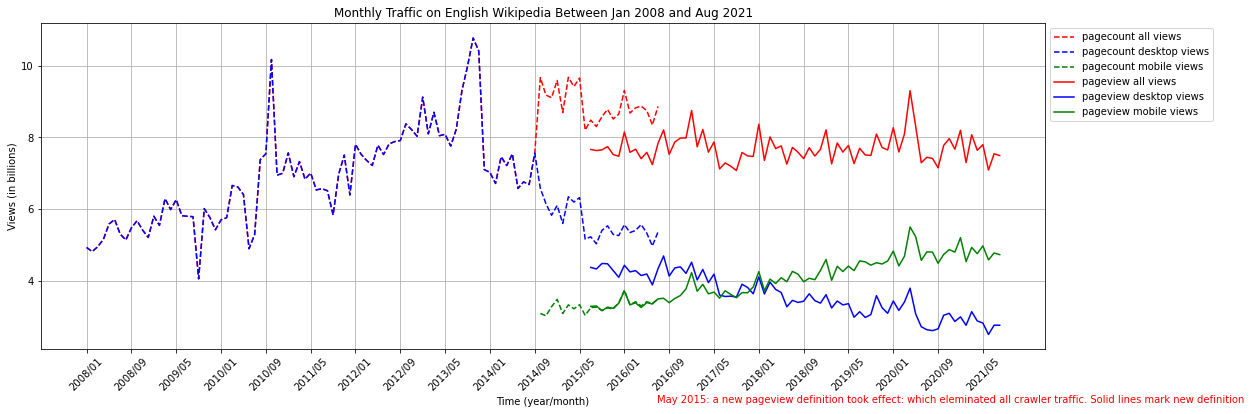

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
plt.plot(df["year"] + "/" + df["month"], df.pagecount_all_views/1e9, c='r', linestyle='dashed',label="pagecount all views")
plt.plot(df["year"] + "/" + df["month"], df.pagecount_desktop_views/1e9, c='blue', linestyle='dashed',label="pagecount desktop views")
plt.plot(df["year"] + "/" + df["month"], df.pagecount_mobile_views/1e9, c='g', linestyle='dashed',label="pagecount mobile views")
plt.plot(df["year"] + "/" + df["month"], df.pageview_all_views/1e9, c='r', label="pageview all views")
plt.plot(df["year"] + "/" + df["month"], df.pageview_desktop_views/1e9, c='b', label="pageview desktop views")
plt.plot(df["year"] + "/" + df["month"], df.pageview_mobile_views/1e9, c='g', label="pageview mobile views")
plt.xticks((df["year"] + "/" + df["month"])[::8],  rotation=45)
plt.grid()
plt.ylabel("Views (in billions)")
plt.xlabel("Time (year/month)")
plt.title("Monthly Traffic on English Wikipedia Between Jan 2008 and Aug 2021")
plt.figtext(0.6,0.0, "May 2015: a new pageview definition took effect: which eleminated all crawler traffic. Solid lines mark new definition", color = 'r')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig('../results/wiki_traffic.png', bbox_inches='tight')